In [3]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import xgboost as xgb
from IPython.core.display import display
from sklearn.model_selection import train_test_split
import optuna
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']=300
matplotlib.rcParams['figure.facecolor'] = 'white'
from sklearn import metrics
DATA_DIR = '../../data'

OPTIMIZATION_RESULTS = {
 'quantile_threshold': 0.259206622189107,
 'validation_auc': 0.650661,
    'num_boost_round': 63,
 'booster_params': {
     "objective": "binary:logistic",
  'booster': 'dart',
 'lambda': 0.7225896013434718,
 'alpha': 0.8476167165219851,
 'eta': 0.1914165106980799,
 'gamma': 0.6164638081346552,
 'max_depth': 5,
 'min_child_weight': 17.364925889777172,
 'max_delta_step': 6.592103912246133,
 'subsample': 0.9290213671369183,
 'grow_policy': 'lossguide',
 'sample_type': 'weighted',
 'normalize_type': 'tree',
 'rate_drop': 0.2585019806362811,
 'skip_drop': 0.6615736498476495,
 'eval_metric':'auc'}}


## Load data and Model

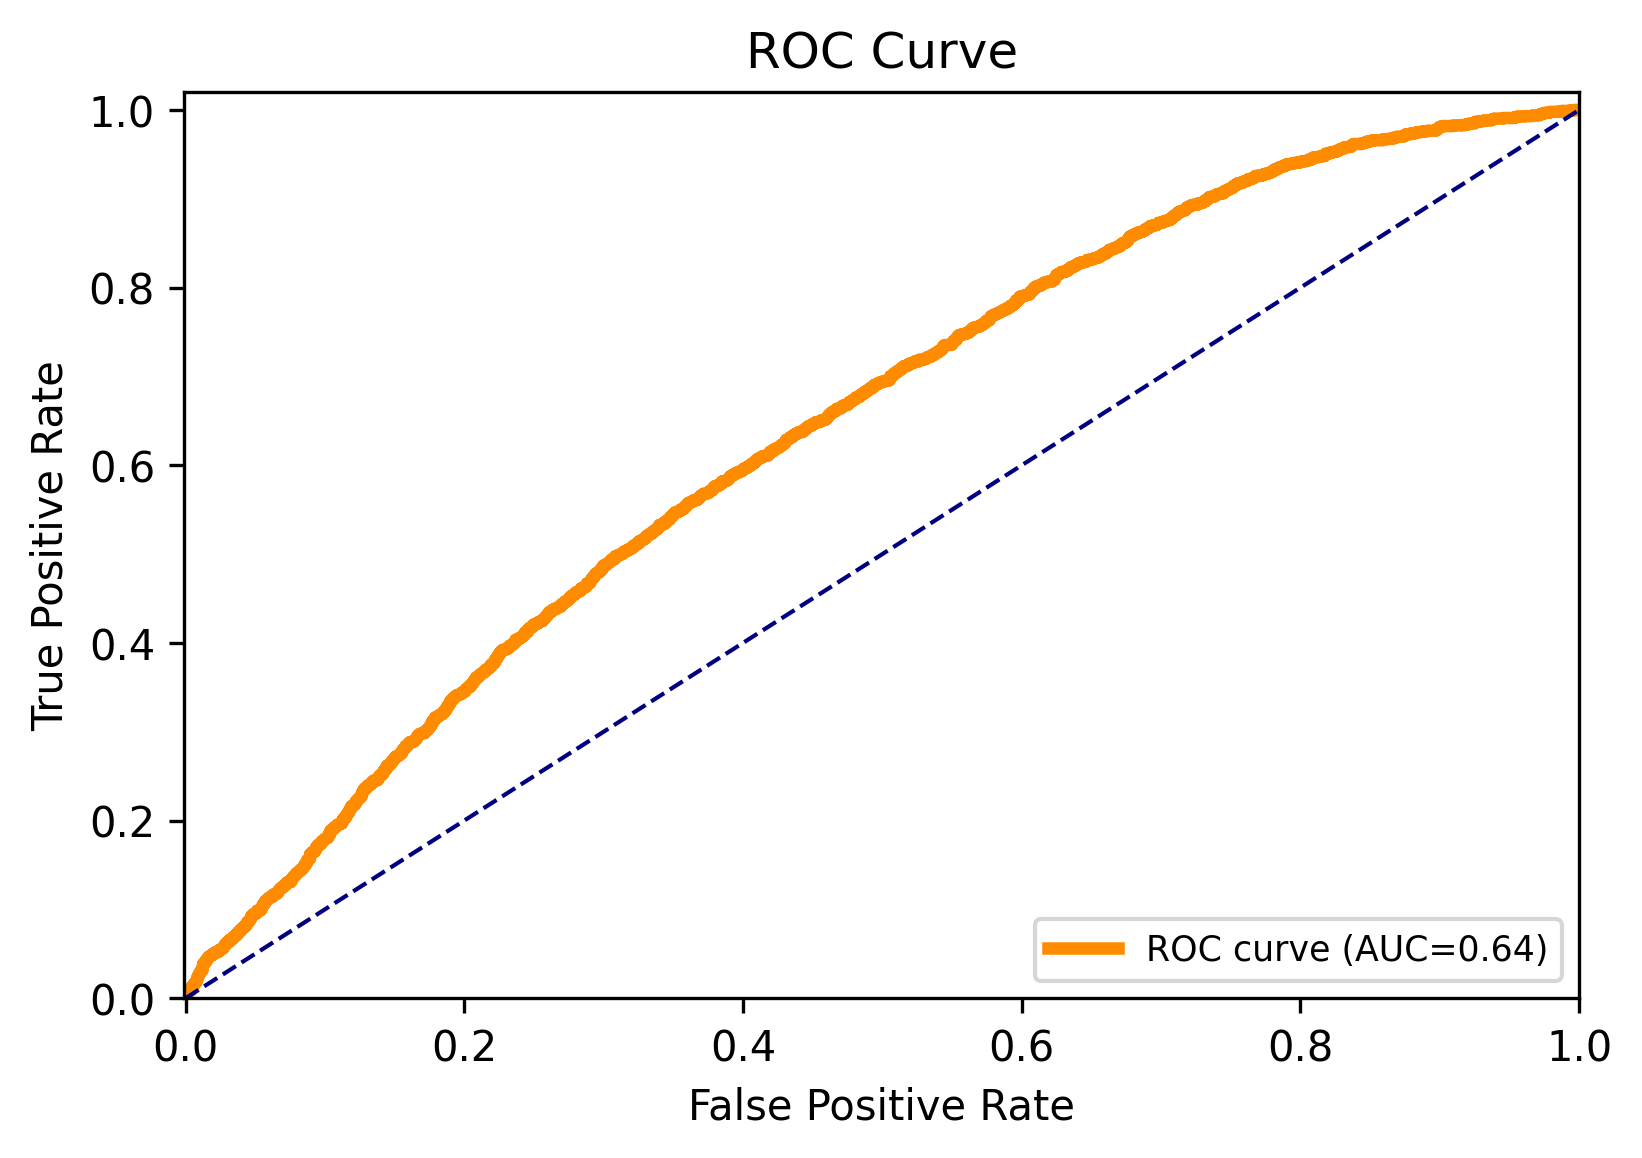

In [4]:
cleaned_features = pd.read_parquet(f'{DATA_DIR}/^cleaned_features.pqt')
psc_score = pd.read_parquet(f'{DATA_DIR}/^proscore_score.pqt')
features_train, features_holdout, score_train, score_holdout = (
    train_test_split(cleaned_features, psc_score["Score"], test_size=0.2, random_state=777)
)
score_threshold = np.quantile(score_train,
                              OPTIMIZATION_RESULTS['quantile_threshold'])
target_train = score_train.apply(lambda r: 1 if r<=score_threshold else 0)
target_holdout = score_holdout.apply(lambda r: 1 if r<=score_threshold else 0)
dmat_train = xgb.DMatrix(features_train,target_train,nthread=-1)
model_bst = xgb.train(params=OPTIMIZATION_RESULTS['booster_params'],
                      dtrain=dmat_train,
                      num_boost_round=OPTIMIZATION_RESULTS['num_boost_round'])
preds = model_bst.predict(xgb.DMatrix(features_holdout))
fpr, tpr, thresholds = metrics.roc_curve(target_holdout, preds)
auc = metrics.auc(fpr,tpr)
fig,ax = plt.subplots()
ax.plot(fpr,tpr,color='darkorange',lw=3, label=f"ROC curve (AUC={auc:.2f})")
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_xlim([-1e-3,1.0])
ax.set_ylim([0.0,1.02])
ax.legend(loc="lower right",fontsize='small')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.show()

In [5]:
%load_ext autoreload
%autoreload 1
%aimport src.confusion_matrix
import src.confusion_matrix as cm


n_cond_pos = (target_holdout==1).sum()
n_cond_neg = (target_holdout==0).sum()
def confusion_matrix(quantile_thres):
    prediction_threshold = np.quantile(preds,quantile_thres)
    pred_pos = preds>prediction_threshold
    pred_neg = preds<=prediction_threshold
    n_pred_pos = pred_pos.sum()
    n_pred_neg = pred_neg.sum()
    n_true_pos = (target_holdout[pred_pos]==1).sum()
    n_false_pos = (target_holdout[pred_pos]==0).sum()
    n_false_neg = (target_holdout[pred_neg]==1).sum()
    n_true_neg = (target_holdout[pred_neg]==0).sum()
    return cm.ConfMatrix(n_true_pos,n_false_pos,n_false_neg,n_true_neg)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
quant_thres = np.linspace(0,1,1000)
quant_2_confmat = ([(qt,
                     confusion_matrix(qt)
                    )
                    for qt in quant_thres])

## Relative profit

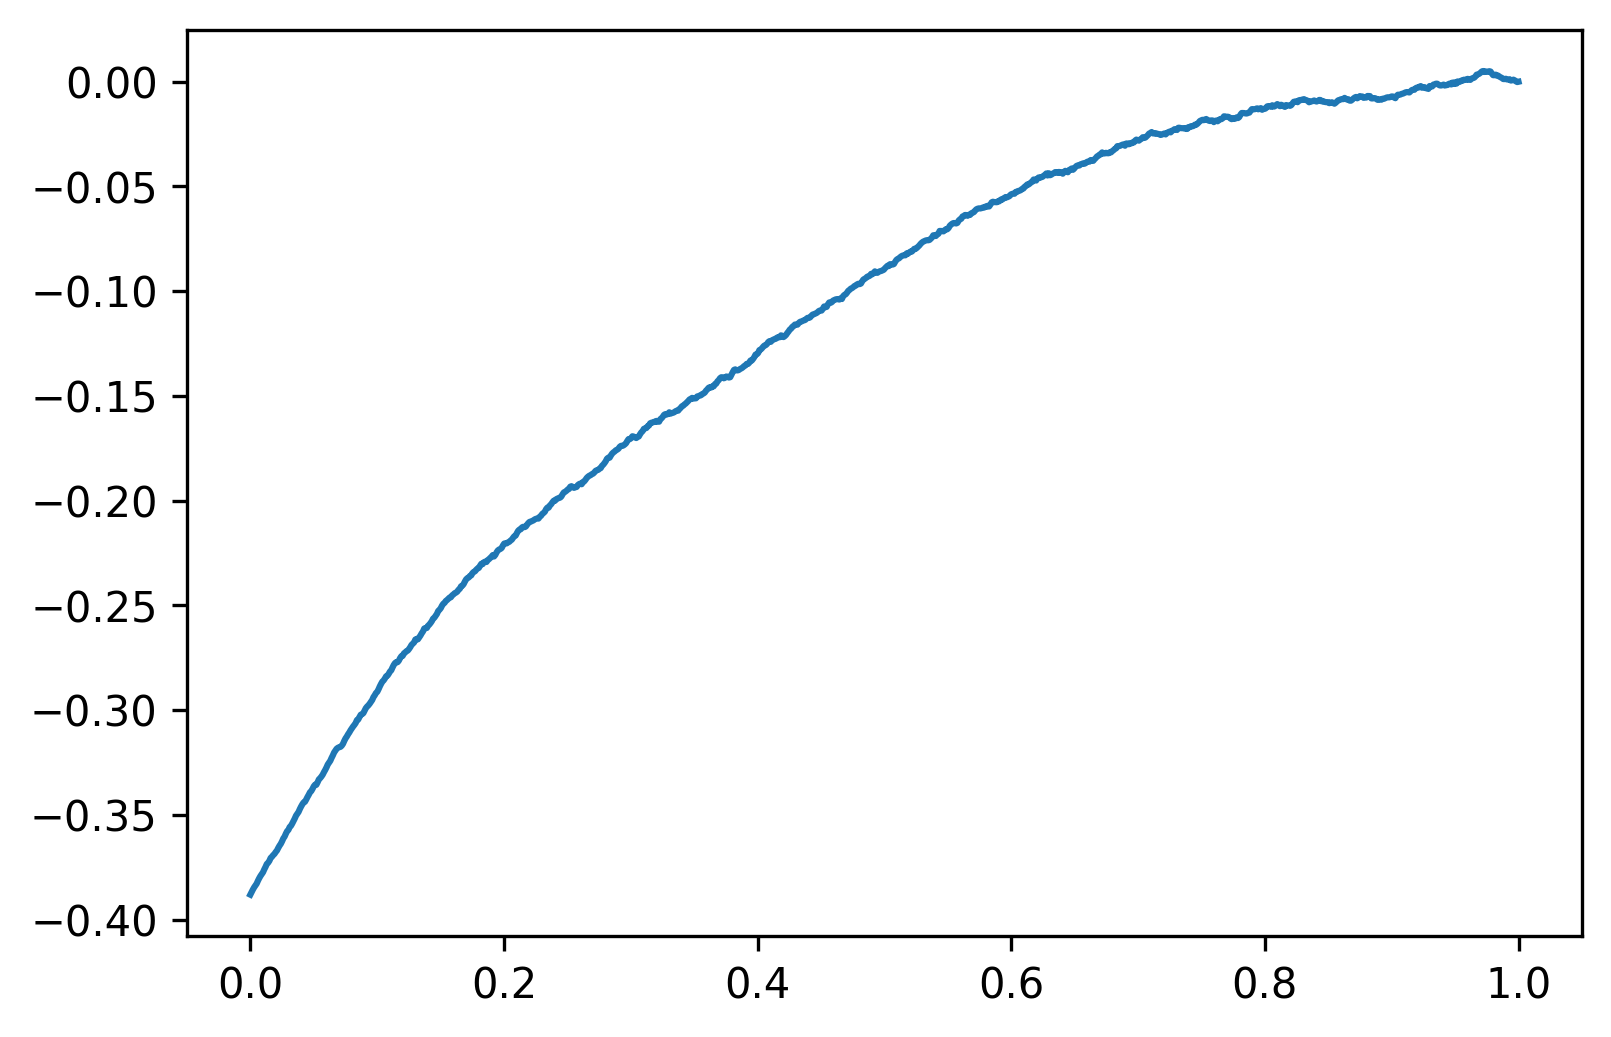

In [25]:
relative_profit_approving_all =0
br = (target_holdout==1).sum()/len(target_holdout)
fee = (relative_profit_approving_all+br)/(1-br)
fig, ax = plt.subplots()
f1_scores = [qc[1].relative_profit(fee) for qc in quant_2_confmat]
ax.plot(quant_thres,f1_scores)

In [26]:
decision_max_profit = max(quant_2_confmat,key=lambda r: r[1].relative_profit(fee))[1]
incremental_relative_profit = decision_max_profit.relative_profit(fee)-relative_profit_approving_all
display(decision_max_profit.display())

In [27]:
average_ticket = 100
sup_lim_price = average_ticket*incremental_relative_profit
print(f"The maximum value we could ask is R${sup_lim_price:.2f}")

The maximum value we could ask is R$0.51
